<a href="https://colab.research.google.com/github/kdambrowski/Alien_Predator_recog_CV/blob/main/CV_alien_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle -q
! pip install validators -q
!pip install -q gradio
# !pip install -q gradio --upgrade
# !pip install -q --upgrade Flask
# !pip install -q --upgrade Pillow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
print(gr.__version__)

3.29.0


# Library

In [2]:
import copy
import os
import os.path
from pathlib import Path
import random
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab.patches import cv2_imshow
import gradio as gr
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split as tts
from tqdm import tqdm, tqdm_notebook


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

# Clasess and functions

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# class SimpleNet(nn.Module):
#   def __init__(self):
#     super(SimpleNet, self).__init__()
#     self.conv1 = nn.Convolution2d(1,16, kernel_size = 3, padding = 1)
#     self.bn1 = nn.BatchNorm2d(16)
#     self.pool1 = nn.MaxPooling2d(kernel_size = 3, stride = 2)
#     self.fc1 = nn.Linear(16*)


class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        return img, label
    
    def __len__(self):
        return len(self.images)


def get_image_dataloader(images,
                         labels,
                         batch_size = 32,
                         shuffle=True,
                         num_workers = 2):
    dataset = ImageDataset(images, labels)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers = num_workers)
    return dataloader

def download_unzip_file(file_name):
  if not os.path.isfile(file_name):
    !kaggle datasets download -d pmigdal/alien-vs-predator-images
    !unzip -q /content/alien-vs-predator-images.zip
    print(f'files have been downloaded and unzipped successfuly')
  else:
    print('directed file exist on selected path')

def jpg_file_renamed(folder_path, prefix, sufix_counter=False):
  """Changing name of files in indicated folder, add to regular name prefix
  and is possibility to add sufix_counter on the end of regular name.
  Sufix starts with 0 value
  """
  prefix_str = str(prefix)
  additional_slash = '/'
  folder_path_slash = folder_path + additional_slash
  folder_elements = os.listdir(folder_path_slash)
  if sufix_counter:
    sufix_counter = 0
    for file_name in folder_elements:
      source = folder_path_slash + file_name
      destination = folder_path_slash + prefix+"_" + file_name + str(sufix_counter)
      #result = ....ColoredDiceDataset/1/prefix000108sufix.jpg
      os.rename(source, destination)
      sufix_counter +=1
  else:          
    for file_name in folder_elements:
      source = folder_path_slash + file_name
      destination = folder_path_slash + prefix +"_" + file_name
      #result = ....ColoredDiceDataset/1/1000108.jpg
      os.rename(source, destination)
  previous_example_2_eg = sorted(folder_elements)[:2]
  results_2_eg= sorted(os.listdir(folder_path))[:2]
  return print('All files renamed successfully in indicated path',
               f'\nprevious name: {previous_example_2_eg}',
               f'\ncurrent name:{results_2_eg}\n')
   
def rename_files(root_path, searched_dir_name_1, searched_dir_name_2):  
  for root, dirs, files in os.walk(root_path):
    if searched_dir_name_1 in dirs:
      direct_path = os.path.join(root, searched_dir_name_1)
      jpg_file_renamed(direct_path, searched_dir_name_1[:2])
    if searched_dir_name_2 in dirs:
      direct_path = os.path.join(root, searched_dir_name_2)
      jpg_file_renamed(direct_path, searched_dir_name_2[:2])

def set_dimension_img(image, heigh, width):
  """function for set define dimennsion for picture"""
  picture_dimension = (heigh, width)
  return cv2.resize(image,picture_dimension)

def get_img_list(serched_path, img_id_df):
  img_list = []
  for img_id in img_id_df:
    for root, dir, file in os.walk(serched_path):
      if img_id in file:
        img_path = os.path.join(root, img_id)
        img_list.append(cv2.imread(img_path))
  return img_list

def manual_train_test_split(df, percentage):
  df_split_val = round(len(df)*percentage)
  if type(df) == 'pandas.core.frame.DataFrame':
    train_df = df[:df_split_val]
    test_df = df[df_split_val:]
  else:
    train_df = df[:df_split_val]
    test_df = df[df_split_val:]
  return train_df, test_df

def val_pt_model(testing_pic):
    if not testing_pic:
        return "No image input provided"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model.to(device)
    loaded_model.eval()
    with torch.inference_mode():
        inputs = pic_transformation(testing_pic)
        inputs = inputs.to(device)
        out = loaded_model(inputs)
        pred_proba = torch.sigmoid(out) 
        pred = torch.where(pred_proba > 0.5, 1,0).squeeze()
        if pred:
            pred = 'Predator'
        else:
            pred = 'Alien' 
    return pred


def updated_training_pt_model(model, train_loader, criterion, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses = []
    train_accs = []
    for epoch in range(epochs):
        progress_bar = tqdm_notebook(train_loader, leave=False)
        batch_losses = []
        acc, count = 0, 0
        model.train() # czemu to nie jest w loopie epoch
        # total_correct_preds = 0 # to chyba jest źle powinno być poza loopem
        # total_preds = 0 #to tez wywalić z tego miejsca
        for inputs, target in progress_bar:
            inputs = inputs.view(-1, 1, 128, 128)
            inputs = inputs.to(device)
            target = target.to(device)

            # model.zero_grad() # tu chyba optimalizer powinien być zerowany
            output = model(inputs)
            loss = criterion(output.squeeze(), target.float())
            loss.backward()              
            nn.utils.clip_grad_norm_(model.parameters(), 3) # muszę sprawdzić co to robi
            # optimizer.zero_grad()
            optimizer.step()
            progress_bar.set_description(f'Loss: {loss.item():.3f}')
            batch_losses.append(loss.item()) # czemu tu item()
            

            # print(f'OUTPUT{output.squeeze()}')
            pred_proba = torch.sigmoid(output)
            pred = torch.where(pred_proba>0.5, 1,0).squeeze()
            # print(f'pred  {pred.squeeze()}\n')
            # print(f'\n TARGET {target}')
            # print((pred == target).sum())
            

            # print(acc)
            acc += (pred == target).sum()
            count += len(target)

            # _, predicted = torch.max(output, 1)
            # predicted = predicted.to(device)
            # total_correct_preds += (predicted == target).sum().item()
            # total_preds += len(target)

        epoch_loss = sum(batch_losses) / len(batch_losses) 
        # dlaczego tu zbierac średni loss a nie pokazywać go realnego
        train_losses.append(epoch_loss)

        epoch_acc = (acc / count) * 100
        train_accs.append(epoch_acc)
        
        tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.5f} \tTrain ACC: {epoch_acc:.5f}')

    acc_total = sum(train_accs) / len(train_accs)
    tqdm.write(f'Total Train ACC: {acc_total:.5f}')
    # return train_losses, train_accs

def train_test_pt_model(model,
                        train_loader,
                        test_loader,
                        criterion,
                        optimizer,
                        epochs = 10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  train_losses = []
  train_accs = []
  epochs_loop = []

  test_losses = []
  test_epoch_acc = []
  for epoch in range(epochs):
      progress_bar = tqdm_notebook(train_loader, leave=False)
      batch_losses = []
      test_batch_losses = []
      epochs_loop.append(epoch+1)
      acc, count, test_acc, test_count = 0, 0, 0, 0
      model.train() # czemu to nie jest w loopie epoch
      # total_correct_preds = 0 # to chyba jest źle powinno być poza loopem
      # total_preds = 0 #to tez wywalić z tego miejsca

      for inputs, target in progress_bar:
          inputs = inputs.view(-1, 1, 128, 128)
          inputs = inputs.to(device)
          target = target.to(device)

          model.zero_grad() # tu chyba optimalizer powinien być zerowany
          output = model(inputs)
          loss = criterion(output.squeeze(), target.float())
          loss.backward()              
          nn.utils.clip_grad_norm_(model.parameters(), 3) # muszę sprawdzić co to robi
          optimizer.step()
          progress_bar.set_description(f'Loss: {loss.item():.3f}')
          batch_losses.append(loss.item()) # czemu tu item()
          
          pred_proba = torch.sigmoid(output)
          pred = torch.where(pred_proba>0.5, 1,0).squeeze()
          acc += (pred == target).sum()
          count += len(target)

      model.eval()
      with torch.inference_mode():
        for test_input, test_target in test_loader:
          test_input = test_input.view(-1, 1, 128, 128)
          test_input = test_input.to(device)
          test_target = test_target.to(device)

          test_out = model(test_input).squeeze()
          test_pred = torch.round(torch.sigmoid(test_out))
          test_loss = criterion(test_out, test_target.float())
          test_batch_losses.append(test_loss.item())
          test_acc += (test_pred == test_target).sum()
          test_count += len(test_target)
    

      epoch_loss = sum(batch_losses) / len(batch_losses) 
      train_losses.append(epoch_loss)
      epoch_acc = (acc / count) * 100
      train_accs.append(epoch_acc.item())

      test_epoch_loss = sum(test_batch_losses) / len(test_batch_losses) 
      test_losses.append(test_epoch_loss)
      epoch_test_acc = (test_acc / test_count) * 100
      test_epoch_acc.append(epoch_test_acc.item())
      
      if not epoch % 10:
        tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.5f} \tTrain ACC: {epoch_acc:.5f}')
        tqdm.write(f'Epoch #{epoch + 1}\tTest Loss: {test_epoch_loss:.5f} \tTest ACC: {epoch_test_acc:.5f}\n')
  return train_losses, train_accs, test_losses, test_epoch_acc, epochs_loop

def draw_test_train_plot(train_losse, train_acc, test_loss = None, test_acc = None):
  epoch_range = range(1, len(train_losse)+1)
  acc_color = 'r'
  loss_color = 'b'
  if test_acc is not None and test_loss is not None: 
    fig, ax = plt.subplots(2,1, sharex = True)
    ax[0].set_title('Train_test LOSS and ACC plot throu trainings epochs')
    ax[0].plot(epoch_range, train_losse, label = 'train_loss', color = loss_color)
    ax[0].plot(epoch_range, test_loss, label = 'test_loss', color = loss_color, linestyle = '--')
    ax[0].set_ylabel('Loss value')
    ax[0].legend()

    ax[1].plot(epoch_range, train_acc, label = 'train_acc',  color = acc_color)
    ax[1].plot(epoch_range, test_acc, label = 'test_acc',  color = acc_color, linestyle = '--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('ACC value')
    ax[1].legend()
  else:
    fig, ax = plt.subplots()
    plt.title('Train LOSS and ACC plot through trainings epochs')
    ax.plot(epoch_range, train_losses, label = 'train_loss', color = loss_color)
    ax.set_xlabel('epochs')
    ax.set_ylabel('Loss value')

    ax2=ax.twinx()
    ax2.plot(epoch_range, train_acc, label = 'train_acc', color = acc_color)

    ax2.set_ylabel('ACC value')
    ax2.tick_params('y', colors = acc_color)
    ax.legend()
    ax2.legend()

  plt.show()

def label_image_aug_sets(aug_num, labels_df, img_list, aug_propability):
  stacked_label_aug_times = pd.concat([labels_df] * aug_num,
                                       axis = 0,
                                       ignore_index = True)
  img_aug_list = img_list.copy()
  for seed_no in range(1, aug_num):
    iaa.ia.seed(seed_no)
    seq = iaa.Sequential([
            iaa.Sometimes(aug_propability,
                          iaa.Affine(rotate=(-25, 25))),
            iaa.Sometimes(aug_propability,
                          iaa.AdditiveGaussianNoise(scale=(10, 41))),
            iaa.Sometimes(aug_propability,
                          iaa.Crop(percent=(0, 0.2)))
        ])

    for aug_img in seq(images = img_list):
      img_aug_list.append(aug_img)
  return img_aug_list, stacked_label_aug_times

def save_model(model, dic_name, model_name):
    MODEL_PATH = Path(dic_name)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    MODEL_SAVE_PATH = MODEL_PATH / (model_name + '.pth')
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    status = f'Model has been saved to: {MODEL_SAVE_PATH}'
    print(status)
    return str(MODEL_SAVE_PATH)

def load_model(model_class, saved_model_path):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(saved_model_path))
  loaded_model.to(device)
  print(f"Loaded model structure:\n{loaded_model}\n\nModel on device:\n{next(loaded_model.parameters()).device}")
  return loaded_model

def mean_std_average_color(data_dir_train):
  image_datasets = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())
  dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)
  data_img_mean = 0.
  data_img_std = 0.
  num_samples = len(image_datasets)

  for data in dataloader:
      img = data[0]
      batch_samples = img.size(0)
      channels = img.size(1)
      pixels = img.view(batch_samples, channels, -1)
      data_img_mean += pixels.mean(2).sum(0)
      data_img_std += pixels.std(2).sum(0)
  data_img_mean /= num_samples
  data_img_std /= num_samples

  print(f"Mean for all colors chanels: {data_img_mean}")
  print(f"Standard deviation for all colors chanels: {train_std}")
  return data_img_mean, data_img_std

def visualize_samples(dataloaders, class_names, mean, std, num_samples=9, figsize=(8, 8)):
  fig = plt.figure(figsize=figsize)
  rows, cols = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
  
  for i in range(1, rows*cols + 1):
      pic, classes = next(iter(dataloaders))
      pic = pic[0].permute(1, 2, 0)
      pic = torch.from_numpy(pic.numpy())
      pic = (pic * std) + mean
      pic = np.clip(pic.numpy(), 0, 1)
      ax = fig.add_subplot(rows, cols, i)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(pic)
      ax.set_title(class_names[classes[0]])
  
  plt.tight_layout()
  plt.show()

def train_model_rn(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    list_train_epoch_acc, list_train_epoch_loss = [], []
    list_val_epoch_acc, list_val_epoch_loss = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            train_epoch_loss = running_loss / dataset_sizes[phase]
            list_train_epoch_loss.append(train_epoch_loss)
            train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list_train_epoch_acc.append(train_epoch_acc)


            print(f'{phase} Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')

            # deep copy the model
            if phase == 'validation':
              val_loss = running_loss / dataset_sizes[phase]
              list_val_epoch_loss.append(val_loss)
              val_acc = running_corrects.double() / dataset_sizes[phase]
              list_val_epoch_acc.append(val_acc)

              if train_epoch_acc > best_acc:
                best_acc = train_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, list_train_epoch_loss, list_train_epoch_acc, list_val_epoch_loss, list_val_epoch_acc

# Files preparation

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Colab_Notebooks/Upskill/Computer_vision_alien_predator/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json


In [10]:
download_unzip_file('alien-vs-predator-images.zip')

 28% 4.00M/14.1M [00:00<00:00, 26.2MB/s]
100% 14.1M/14.1M [00:00<00:00, 62.4MB/s]
files have been downloaded and unzipped successfuly


In [11]:
rename_files('/content/data', 'alien', 'predator')

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['al_0.jpg', 'al_1.jpg']

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['pr_0.jpg', 'pr_1.jpg']

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['al_0.jpg', 'al_1.jpg']

All files renamed successfully in indicated path 
previous name: ['0.jpg', '1.jpg'] 
current name:['pr_0.jpg', 'pr_1.jpg']



# EDA

In [12]:
train_percentage_div = 0.8

In [13]:
train_pred_file_list = os.listdir('/content/data/train/predator')
val_pred_file_list = os.listdir('/content/data/validation/predator')

train_alien_file_list = os.listdir('/content/data/train/alien')
val_alien_file_list = os.listdir('/content/data/validation/alien')

In [14]:
train_pred_df = pd.DataFrame(data = train_pred_file_list, columns = ['image_name'] )
val_pred_df = pd.DataFrame(data = val_pred_file_list, columns = ['image_name'] )

train_pred_df['is_predator'] = np.ones(len(train_pred_df.index))
val_pred_df['is_predator'] = np.ones(len(val_pred_df.index))

In [15]:
train_alien_df = pd.DataFrame(data = train_alien_file_list, columns= ['image_name'])
val_alien_df = pd.DataFrame(data = val_alien_file_list, columns= ['image_name'])

train_alien_df['is_predator'] = np.zeros(len(train_alien_df.index))
val_alien_df['is_predator'] = np.zeros(len(val_alien_df.index))

In [16]:
train_images_df = pd.concat([train_alien_df, train_pred_df])
val_images_df = pd.concat([val_alien_df, val_pred_df])

In [17]:
train_images_df = train_images_df.sample(frac=1).reset_index(drop = True)
train_images_df

,image_name,is_predator
0,pr_79.jpg,1.0
1,al_190.jpg,0.0
2,al_290.jpg,0.0
3,al_118.jpg,0.0
4,al_81.jpg,0.0
...,...,...
689,al_230.jpg,0.0
690,al_48.jpg,0.0
691,al_187.jpg,0.0
692,pr_236.jpg,1.0


In [18]:
val_images_df = val_images_df.sample(frac=1).reset_index(drop = True)
val_images_df

,image_name,is_predator
0,al_3.jpg,0.0
1,pr_86.jpg,1.0
2,al_46.jpg,0.0
3,al_35.jpg,0.0
4,al_4.jpg,0.0
...,...,...
195,al_22.jpg,0.0
196,pr_96.jpg,1.0
197,al_40.jpg,0.0
198,pr_99.jpg,1.0


In [19]:
print(f'TRAIN DF \n{train_images_df.is_predator.value_counts(normalize = True)}\n')
print(f'VAL DF \n{val_images_df.is_predator.value_counts(normalize = True)}')

TRAIN DF 
1.0    0.5
0.0    0.5
Name: is_predator, dtype: float64

VAL DF 
0.0    0.5
1.0    0.5
Name: is_predator, dtype: float64


In [20]:
train_img_list = get_img_list('/content/data/train', train_images_df['image_name'])
train_img_list = [set_dimension_img(img, 128, 128) for img in train_img_list]

In [21]:
val_img_list = get_img_list('/content/data/validation', val_images_df['image_name'])
val_img_list = [set_dimension_img(img, 128, 128) for img in val_img_list]

In [22]:
train_gray_img_list = [cv2.cvtColor(image,
                              cv2.COLOR_BGR2GRAY) for image in train_img_list]


# Augmentation

In [23]:
def label_image_aug_sets(aug_num, labels_df, img_list, aug_propability):
  stacked_label_aug_times = pd.concat([labels_df] * aug_num,
                                       axis = 0,
                                       ignore_index = True)
  img_aug_list = img_list.copy()
  for seed_no in range(1, aug_num):
    iaa.ia.seed(seed_no)
    seq = iaa.Sequential([
            iaa.Sometimes(aug_propability,
                          iaa.Affine(rotate=(-25, 25))),
            iaa.Sometimes(aug_propability,
                          iaa.AdditiveGaussianNoise(scale=(10, 41))),
            iaa.Sometimes(aug_propability,
                          iaa.Crop(percent=(0, 0.2)))
        ])

    for aug_img in seq(images = img_list):
      img_aug_list.append(aug_img)
  return img_aug_list, stacked_label_aug_times

In [24]:
aug_img_list, aug_labels = label_image_aug_sets(10,
                                                train_images_df.is_predator,
                                                train_gray_img_list, 
                                                0.8)
len(aug_labels), len(aug_img_list)

(6940, 6940)

# Modeling

## Only scale and gray

In [25]:
# X_train, X_test, y_train, y_test = tts(train_gray_img_list,
#                                                     train_images_df['is_predator'],                                        
#                                                     train_size = train_percentage_div,
#                                                    shuffle = True)

# train_img = torch.Tensor(X_train)
# train_df = y_train.reset_index(drop = True)
# train_tensor_label = torch.Tensor(y_train)

# model = ConvNet()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# dataloader = get_image_dataloader(train_img,
#                                   train_tensor_label,
#                                   batch_size=32,
#                                   shuffle=True,
#                                   num_workers=2)

# test_label = y_test.reset_index(drop = True)
# test_tensor_label = torch.Tensor(test_label)
# test_tensor_img = torch.Tensor(X_test)
# test_loader = get_image_dataloader(test_tensor_img,
#                                    test_tensor_label,
#                                    batch_size=32,
#                                    shuffle=True,
#                                    num_workers=2)

# train_losses, train_accs, test_losses, test_epoch_acc, _ = train_test_pt_model(model,
#                                                                             dataloader,
#                                                                             test_loader,
#                                                                             criterion,
#                                                                             optimizer,
#                                                                             epochs=50)

In [26]:
# draw_test_train_plot(train_losses[-10:], train_accs[-10:], test_losses[-10:], test_epoch_acc[-10:])

## Modeling with augmentation

In [27]:
aug_img_train, aug_img_test, aug_y_train, aug_y_test = tts(aug_img_list,
                                                    aug_labels,                                        
                                                    train_size = train_percentage_div,
                                                   shuffle = True)

aug_y_train = aug_y_train.reset_index(drop = True)
train_tensor_label= torch.Tensor(aug_y_train)
aug_img_train = torch.Tensor(np.array(aug_img_train))
dataloader = get_image_dataloader(aug_img_train,
                                  train_tensor_label,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=2)


aug_y_test = aug_y_test.reset_index(drop = True)
test_tensor_label = torch.Tensor(aug_y_test)
test_tensor_img = torch.Tensor(np.array(aug_img_test))
test_loader = get_image_dataloader(test_tensor_img,
                                   test_tensor_label,
                                   batch_size=32,
                                   shuffle=True,
                                   num_workers=2)

aug_model = ConvNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(aug_model.parameters(), lr=0.001)



aug_train_losses, aug_train_accs, aug_test_losses, aug_test_epoch_acc, _ = train_test_pt_model(aug_model,
                                                                            dataloader,
                                                                            test_loader,
                                                                            criterion,
                                                                            optimizer,
                                                                            epochs = 40)

<ipython-input-7-785a4b240354>:226: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #1	Train Loss: 3.28906 	Train ACC: 55.96182
Epoch #1	Test Loss: 0.69510 	Test ACC: 60.87896



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.17735 	Train ACC: 92.30907
Epoch #11	Test Loss: 0.51324 	Test ACC: 83.21326



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.02893 	Train ACC: 99.08141
Epoch #21	Test Loss: 0.75952 	Test ACC: 85.37464



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.02217 	Train ACC: 99.40562
Epoch #31	Test Loss: 0.97748 	Test ACC: 85.66283



  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

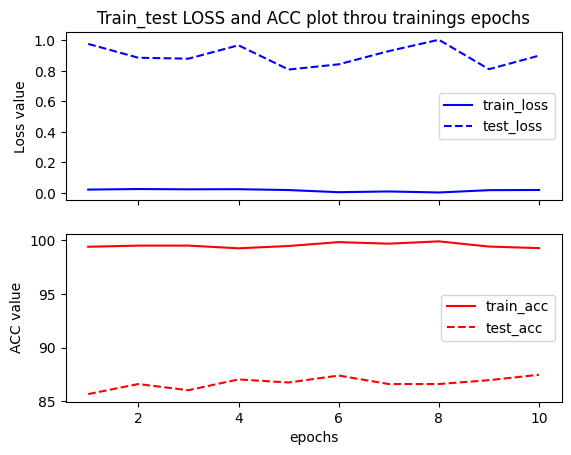

In [28]:
draw_test_train_plot(aug_train_losses[-10:], aug_train_accs[-10:], aug_test_losses[-10:], aug_test_epoch_acc[-10:])

# Save best model

In [29]:
saved_model_path = save_model(aug_model, 'saved_models', 'aug_model_0')


Model has been saved to: saved_models/aug_model_0.pth


In [30]:
print(saved_model_path)

saved_models/aug_model_0.pth


In [31]:
def load_model(model_class, saved_model_path):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(saved_model_path))
  loaded_model.to(device)
  print(f"Loaded model structure:\n{loaded_model}\n\nModel on device:\n{next(loaded_model.parameters()).device}")
  return loaded_model

In [32]:
loaded_model = load_model(ConvNet(), saved_model_path)

Loaded model structure:
ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

Model on device:
cpu


# Resnet transfer

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transfered_model = models.resnet18(pretrained = True)
# num_ftrs = transfered_model.fc.in_features
# transfered_model.fc = torch.nn.Linear(num_ftrs, 2)
# model_ft = transfered_model.to(device)
# criterion_resnet = nn.CrossEntropyLoss()
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# train_mean, train_std = mean_std_average_color('/content/data/train')

In [ ]:
# val_mean, val_std = mean_std_average_color('/content/data/validation')

In [ ]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(128),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(train_mean, train_std)
#      ]),
#     'validation': transforms.Compose([
#         transforms.Resize(128),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(val_mean, val_std)
#     ]),
# }

# data_dir = '/content/data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'validation']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
#                                              shuffle=True, num_workers=2)
#               for x in ['train', 'validation']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
# class_names = image_datasets['train'].classes

In [ ]:
# visualize_samples(dataloaders['train'],
#                   class_names,
#                   train_mean,
#                   train_std
#                   )

In [ ]:
# model_rn, train_acc, train_loss, val_acc, val_loss = train_model_rn(model_ft,
#                        criterion_resnet,
#                        optimizer,
#                        exp_lr_scheduler,
#                        num_epochs=50)

In [ ]:
# draw_test_train_plot(train_loss, train_acc, val_loss, val_acc)

# Implement GRADIO

In [36]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
from PIL import Image

In [128]:
def pic_transformation(input_img):
    img = Image.fromarray(input_img)
    img = img.convert('L')  # Konwertuj obraz na skale szarosci
    img = img.resize((128, 128))
    img_array = np.array(img)
    return img_array

def val_pt_model(testing_pic):
    if testing_pic is None:
        return "Nie znaleziono obrazka"
    if not testing_pic.any():
        return "Obrazek jest pusty"
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loaded_model.to(device)
        loaded_model.eval()
        with torch.inference_mode():
            inputs = pic_transformation(testing_pic)
            inputs = np.expand_dims(inputs, axis=(0,1))
            inputs = torch.Tensor(inputs)
            inputs = inputs.to(device=device)
            out = loaded_model(inputs)
            pred_proba = torch.sigmoid(out)
            pred = torch.where(pred_proba > 0.5, 1, 0).squeeze()
            if pred:
                pred_label = 'Predator'
                pred_proba = float(pred_proba.squeeze())
            else:
                pred_label = 'Alien'
                pred_proba = 1- float(pred_proba.squeeze())
            return pred_label, pred_proba*100

gr.Interface(fn=val_pt_model, 
             inputs=gr.inputs.Image(source="upload", label="Select a picture"),
             image=gr.inputs.Image(shape=(224, 224), image_mode='RGB'),
             outputs=[gr.outputs.Label(label="Class Name"), gr.outputs.Label(label="Probability")]).launch(debug=True)


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Interface, please remove them: {'image': image}
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
